In [1]:
import os
os.chdir("../../../")

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import scanpy as sc
import scnet as sn
import numpy as np
from sklearn.neighbors import KNeighborsTransformer, DistanceMetric

Using TensorFlow backend.


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
sc.settings.set_figure_params(dpi=100)
sc.settings.figdir = "./results/integration/tabula_senis_mca/"

In [6]:
condition_key = "method_age"
cell_type_key = 'cell_type_union'
target_conditions = ["MCA - 3m", "droplet - 3m", "facs - 3m"]

# Loading Tabula Senis datasets and data preparation

In [7]:
adata = sc.read("./data/tabula_senis_mca/tabula_senis_mca_new_label_consistent_normalized_hvg_subsampled_notebook.h5ad")
adata = adata[~adata.obs['tissue'].isin(['Mammary_Gland'])]
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


View of AnnData object with n_obs × n_vars = 131562 × 5000 
    obs: 'FACS.selection', 'Tech', 'age', 'barcode', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cell_type_union', 'channel', 'free_annotation', 'log_counts', 'marker_gene', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'subtissue', 'tissue', 'tissue_age', 'tissue_free_annotation'
    var: 'n_cells-0-1-0', 'n_cells-1-1-0', 'highly_variable-1-0', 'means-1-0', 'dispersions-1-0', 'dispersions_norm-1-0', 'highly_variable_nbatches-1-0', 'highly_variable_intersection-1-0', 'gene_ids-1-1-1'

In [8]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 49300 × 5000 
    obs: 'FACS.selection', 'Tech', 'age', 'barcode', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cell_type_union', 'channel', 'free_annotation', 'log_counts', 'marker_gene', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'subtissue', 'tissue', 'tissue_age', 'tissue_free_annotation'
    var: 'n_cells-0-1-0', 'n_cells-1-1-0', 'highly_variable-1-0', 'means-1-0', 'dispersions-1-0', 'dispersions_norm-1-0', 'highly_variable_nbatches-1-0', 'highly_variable_intersection-1-0', 'gene_ids-1-1-1'

In [9]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 82262 × 5000 
    obs: 'FACS.selection', 'Tech', 'age', 'barcode', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cell_type_union', 'channel', 'free_annotation', 'log_counts', 'marker_gene', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'subtissue', 'tissue', 'tissue_age', 'tissue_free_annotation'
    var: 'n_cells-0-1-0', 'n_cells-1-1-0', 'highly_variable-1-0', 'means-1-0', 'dispersions-1-0', 'dispersions_norm-1-0', 'highly_variable_nbatches-1-0', 'highly_variable_intersection-1-0', 'gene_ids-1-1-1'

In [10]:
adata_for_training.obs['Tech'].value_counts()

Tabula Senis    49300
Name: Tech, dtype: int64

In [11]:
adata_out_of_sample.obs['Tech'].value_counts()

MCA             42049
Tabula Muris    40213
Name: Tech, dtype: int64

## Train/Test Split

In [12]:
train_adata, valid_adata = sn.utils.train_test_split(adata_for_training, 0.80)

In [13]:
train_adata.shape, valid_adata.shape

((39440, 5000), (9860, 5000))

In [14]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

7

# Create & Train model with training data

In [15]:
network = sn.archs.scNet(x_dimension=train_adata.shape[1], 
                         z_dimension=20,
                         architecture=[512, 128, 32],
                         n_conditions=n_conditions,
                         use_batchnorm=False,
                         lr=0.001,
                         alpha=0.00001,
                         beta=500,
                         eta=1,
                         clip_value=100,
                         loss_fn='sse',
                         mmd_computation_method='5',
                         model_path="./models/CVAE/tabula_senis_mca/before/",
                         dropout_rate=0.05,
                         output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## We assign each study to a numerical label 

In [16]:
train_adata.obs[condition_key].value_counts()

droplet - 30m    9930
droplet - 18m    6603
droplet - 24m    5306
droplet - 21m    5135
facs - 18m       4842
facs - 24m       3878
droplet - 1m     3746
Name: method_age, dtype: int64

In [17]:
conditions = adata_for_training.obs[condition_key].unique().tolist()
condition_encoder = sn.utils.create_dictionary(sorted(conditions), target_conditions)
condition_encoder

{'droplet - 18m': 0,
 'droplet - 1m': 1,
 'droplet - 21m': 2,
 'droplet - 24m': 3,
 'droplet - 30m': 4,
 'facs - 18m': 5,
 'facs - 24m': 6}

## Training the network

In [18]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              n_per_epoch=0,
              batch_size=1024, 
              early_stop_limit=20,
              lr_reducer=15, 
              save=True, 
              retrain=True,
              verbose=5)

Instructions for updating:
Use tf.cast instead.
 |██████--------------| 32.4%  - loss: 660.6931 - reconstruction_loss: 521.1184 - mmd_loss: 139.5748 - val_loss: 796.4485 - val_reconstruction_loss: 523.6029 - val_mmd_loss: 272.8456oss: 54.5860

In [19]:
network.condition_encoder

{'droplet - 18m': 0,
 'droplet - 1m': 1,
 'droplet - 21m': 2,
 'droplet - 24m': 3,
 'droplet - 30m': 4,
 'facs - 18m': 5,
 'facs - 24m': 6}

In [20]:
encoder_labels, _ = sn.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [21]:
latent_adata = network.to_mmd_layer(adata_for_training, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 49300 × 32 
    obs: 'FACS.selection', 'Tech', 'age', 'barcode', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cell_type_union', 'channel', 'free_annotation', 'log_counts', 'marker_gene', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'subtissue', 'tissue', 'tissue_age', 'tissue_free_annotation'

In [22]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [25]:
sn.metrics.entropy_batch_mixing(latent_adata, "method", n_neighbors=15, n_pools=1)

0.11187372319681661

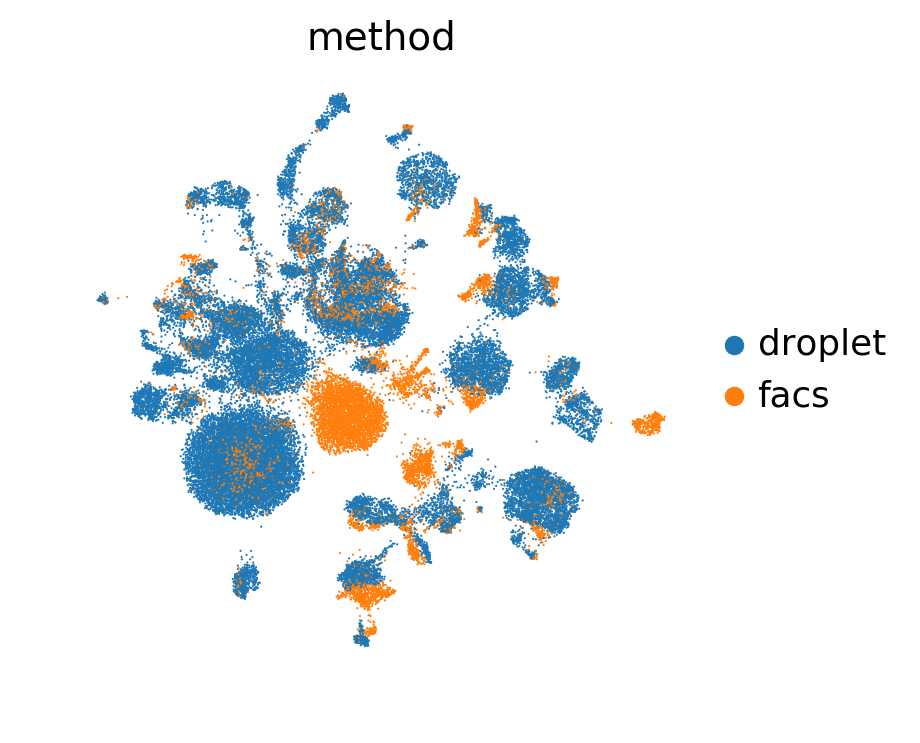

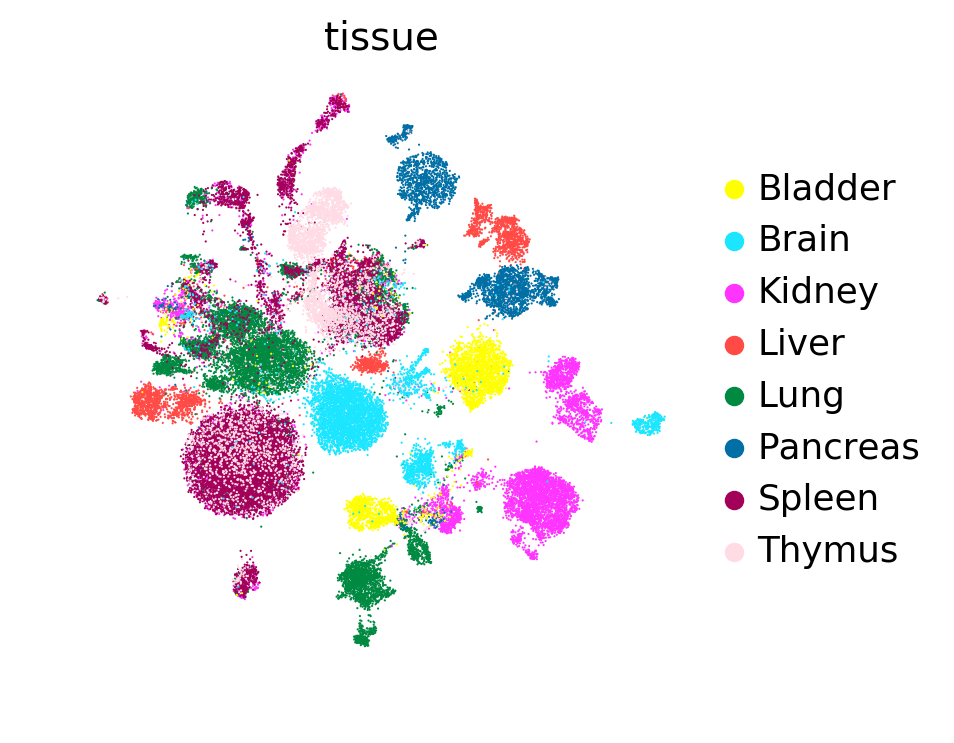

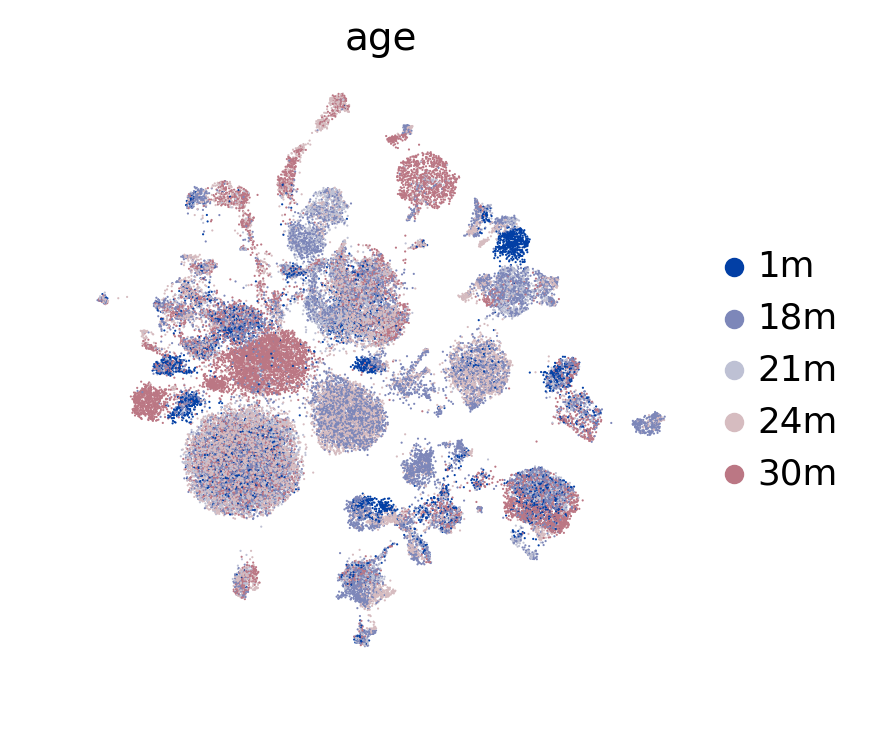

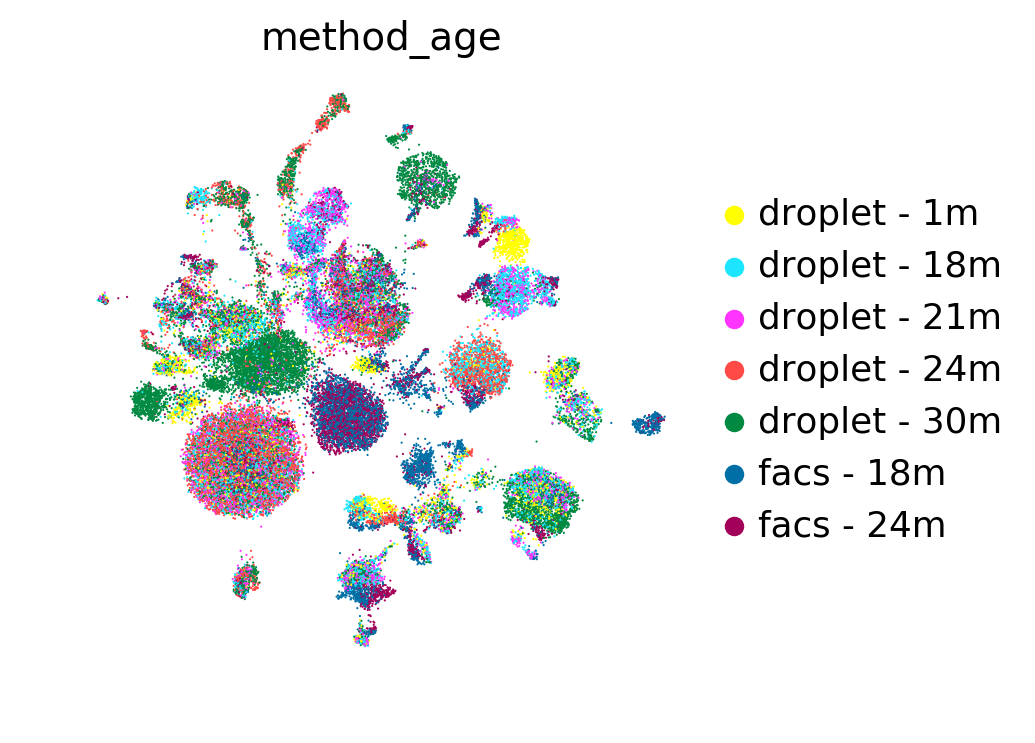

In [23]:
sc.pl.umap(latent_adata, color='method', frameon=False, save='_pretrain_method.pdf')
sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_pretrain_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(latent_adata, color='age', frameon=False, save='_pretrain_age.pdf', palette=sc.pl.palettes.zeileis_28)
sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_pretrain_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)

# Perfroming architecture Surgery

In [26]:
new_network = sn.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True,
                              freeze_expression_input=True,
                              remove_dropout=False,
#                               new_training_kwargs={"beta": 500},
                              new_network_kwargs={"mmd_computation_method": "general"},
                              print_summary=False,
                             )

In [27]:
new_network.condition_encoder

{'droplet - 18m': 0,
 'droplet - 1m': 1,
 'droplet - 21m': 2,
 'droplet - 24m': 3,
 'droplet - 30m': 4,
 'facs - 18m': 5,
 'facs - 24m': 6,
 'MCA - 3m': 7,
 'droplet - 3m': 8,
 'facs - 3m': 9}

## Train with small new dataset containing out-of-sample condition

In [28]:
train_adata, valid_adata = sn.utils.train_test_split(adata_out_of_sample, 0.80)

In [29]:
train_adata.shape, valid_adata.shape

((65809, 5000), (16453, 5000))

In [30]:
new_network.model_path = "./models/CVAE/tabula_senis_mca/after/"

In [31]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=1000,
                  batch_size=1024, 
                  early_stop_limit=20,
                  lr_reducer=10, 
                  n_per_epoch=0,
                  save=True,
                  retrain=True,
                  verbose=5)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


 |█-------------------| 5.9%  - loss: 349.7221 - reconstruction_loss: 346.1464 - mmd_loss: 3.5758 - val_loss: 340.1675 - val_reconstruction_loss: 336.4165 - val_mmd_loss: 3.75108225310516

In [30]:
encoder_labels, _ = sn.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [31]:
adata_out_of_sample.obs[condition_key].value_counts()

MCA - 3m        42049
droplet - 3m    23460
facs - 3m       16753
Name: method_age, dtype: int64

In [32]:
latent_adata = new_network.to_mmd_layer(adata_out_of_sample, encoder_labels, encoder_labels)
latent_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 82262 × 32 
    obs: 'FACS.selection', 'Tech', 'age', 'barcode', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cell_type_union', 'channel', 'free_annotation', 'log_counts', 'marker_gene', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'subtissue', 'tissue', 'tissue_age', 'tissue_free_annotation'

In [33]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

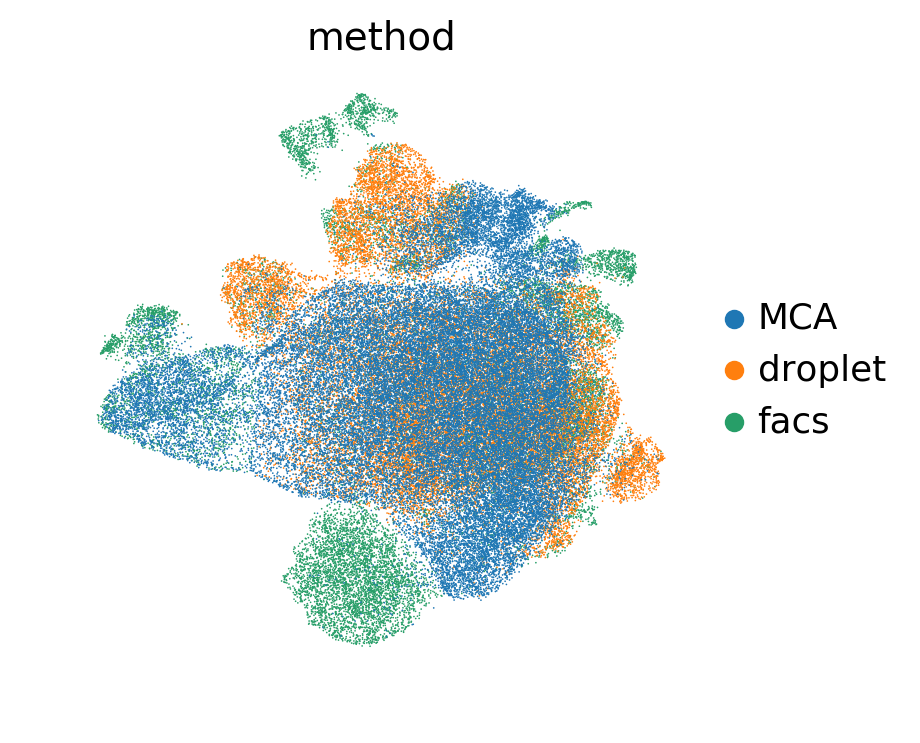

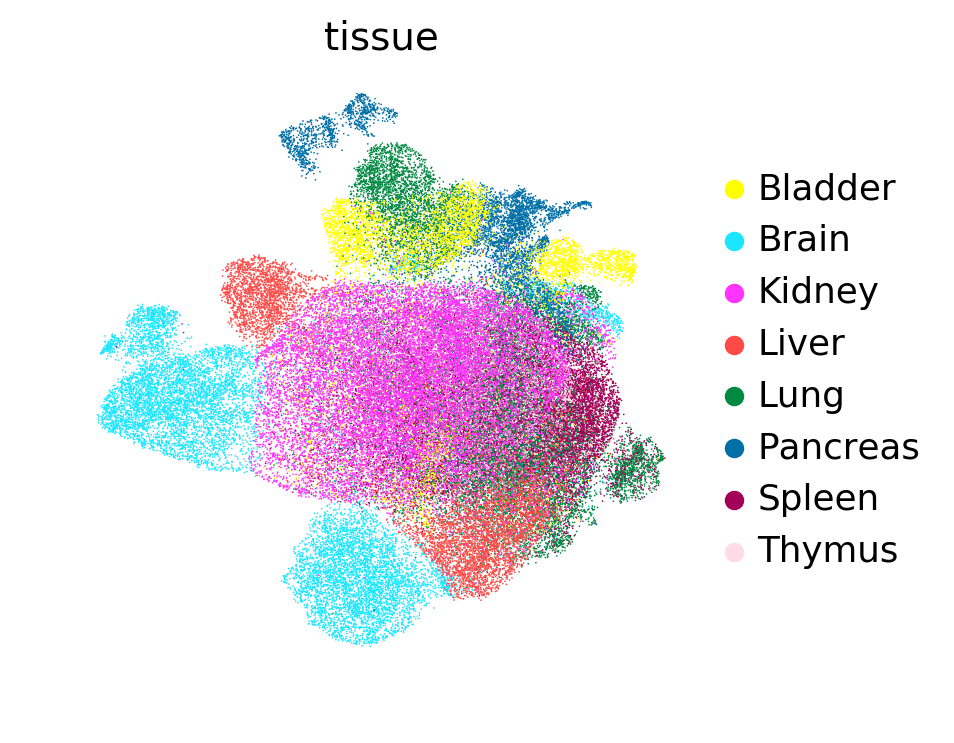

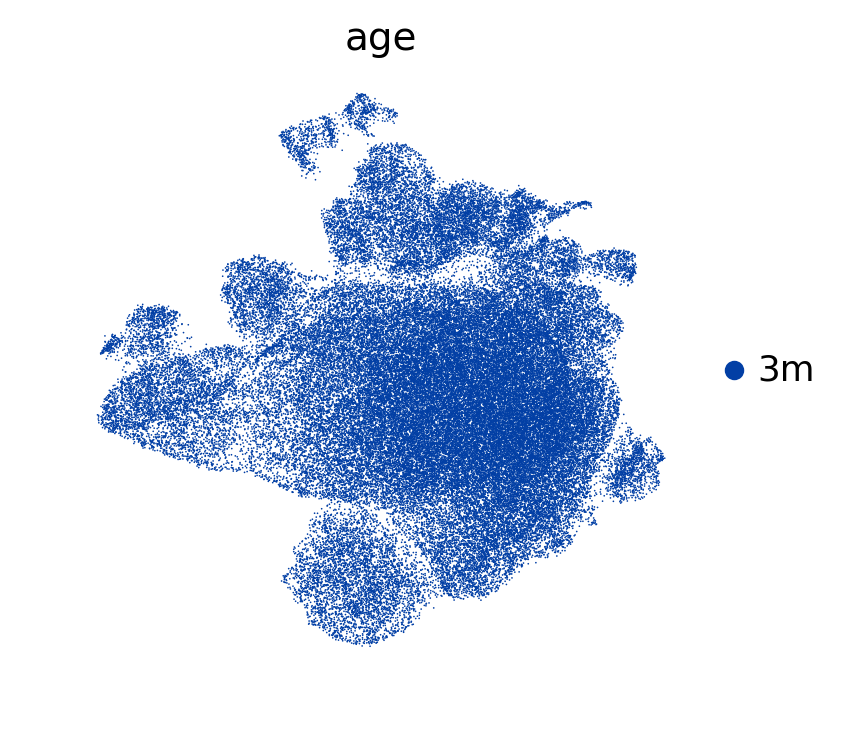

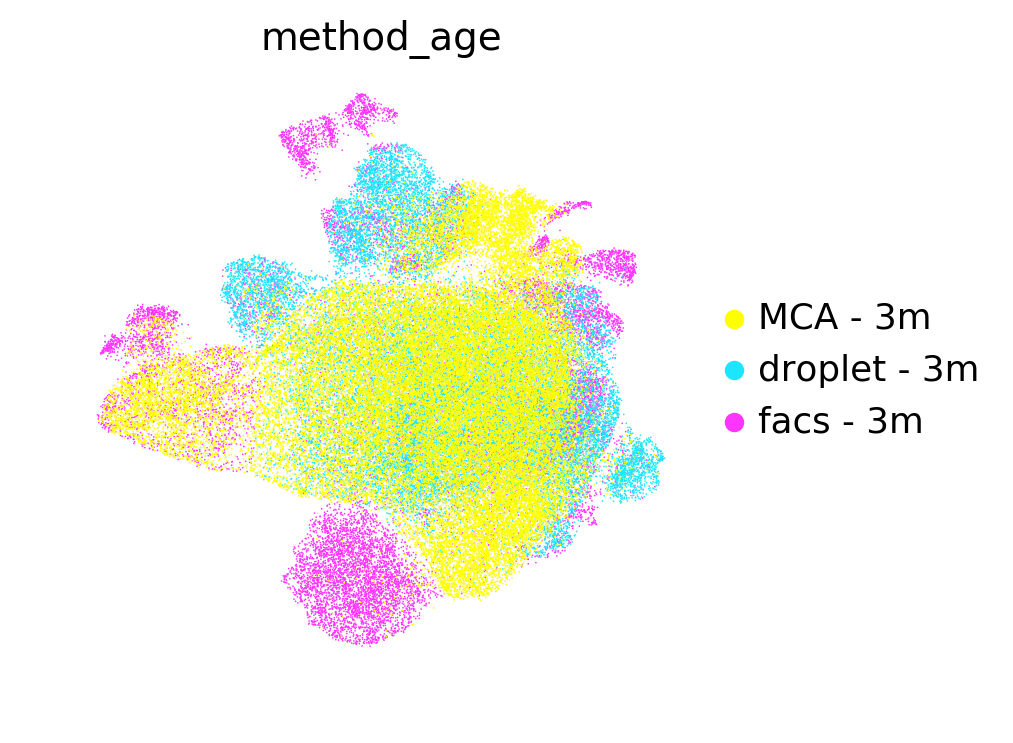

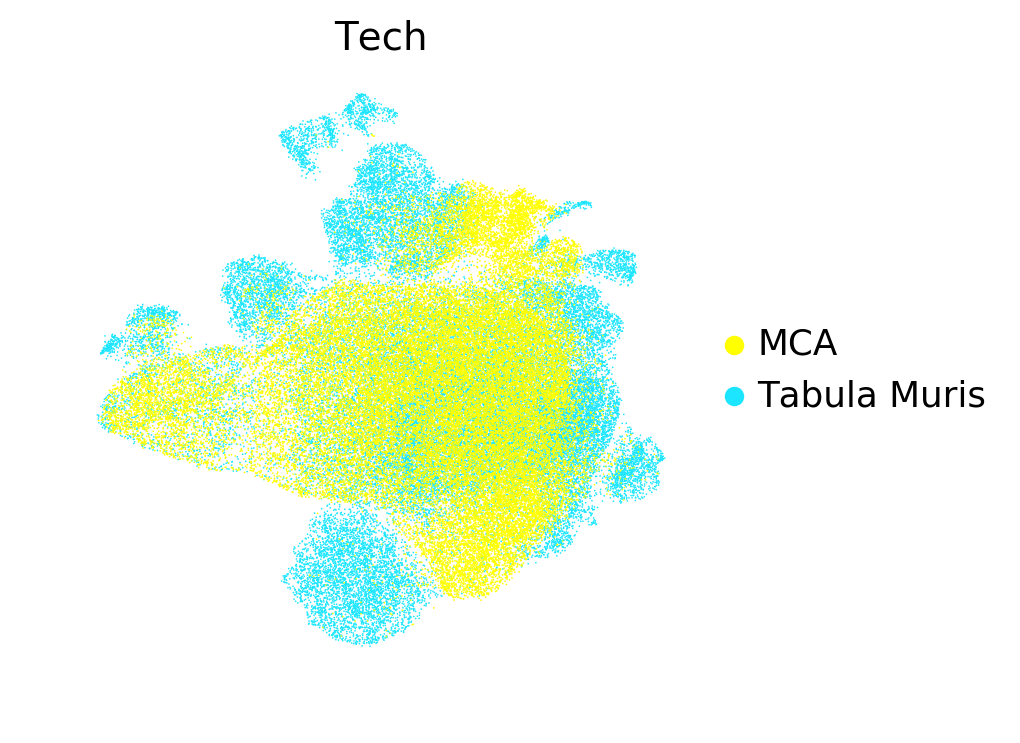

In [34]:
sc.pl.umap(latent_adata, color='method', frameon=False, save='_after_surgery_mca+muris_method.pdf')
sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_after_surgery_mca+muris_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(latent_adata, color='age', frameon=False, save='_after_surgery_mca+muris_age.pdf', palette=sc.pl.palettes.zeileis_28)
sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_after_surgery_mca+muris_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(latent_adata, color='Tech', frameon=False, save=f'_after_surgery_mca+muris_Tech.pdf', palette=sc.pl.palettes.godsnot_102)

In [26]:
adata_out_of_sample = sn.utils.remove_sparsity(adata_out_of_sample)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [27]:
encoder_labels, _ = sn.utils.label_encoder(adata_for_training.concatenate(adata_out_of_sample), label_encoder=new_network.condition_encoder, condition_key=condition_key)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


In [28]:
latent_adata = new_network.to_mmd_layer(adata_for_training.concatenate(adata_out_of_sample), encoder_labels, encoder_labels)
latent_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


AnnData object with n_obs × n_vars = 131562 × 32 
    obs: 'FACS.selection', 'Tech', 'age', 'barcode', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cell_type_union', 'channel', 'free_annotation', 'log_counts', 'marker_gene', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'subtissue', 'tissue', 'tissue_age', 'tissue_free_annotation'

In [29]:
latent_adata.obs['label'] = 'Senis - Muris'

In [30]:
latent_adata.obs.loc[latent_adata.obs['Tech'] == 'MCA', 'label'] = 'MCA'

In [31]:
latent_adata.obs['label'].value_counts()

Senis - Muris    89513
MCA              42049
Name: label, dtype: int64

In [32]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

... storing 'FACS.selection' as categorical
... storing 'Tech' as categorical
... storing 'age' as categorical
... storing 'barcode' as categorical
... storing 'cell' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'cell_type' as categorical
... storing 'cell_type_union' as categorical
... storing 'channel' as categorical
... storing 'free_annotation' as categorical
... storing 'marker_gene' as categorical
... storing 'method' as categorical
... storing 'method_age' as categorical
... storing 'method_tissue' as categorical
... storing 'mouse.id' as categorical
... storing 'sample' as categorical
... storing 'sample_id' as categorical
... storing 'sex' as categorical
... storing 'study' as categorical
... storing 'subtissue' as categorical
... storing 'tissue_free_annotation' as categorical
... storing 'label' as categorical


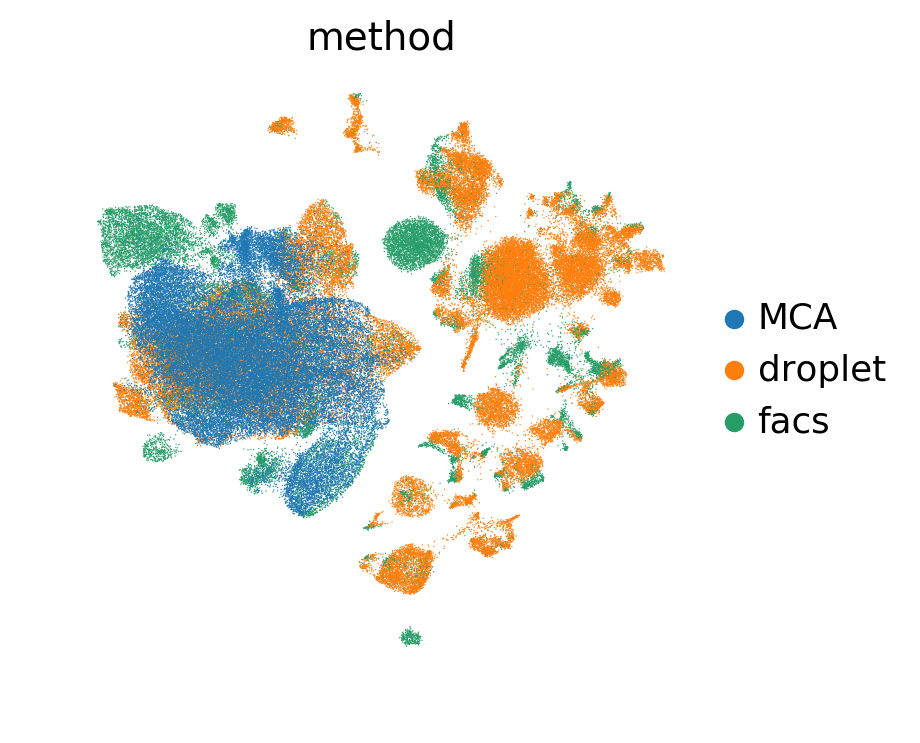

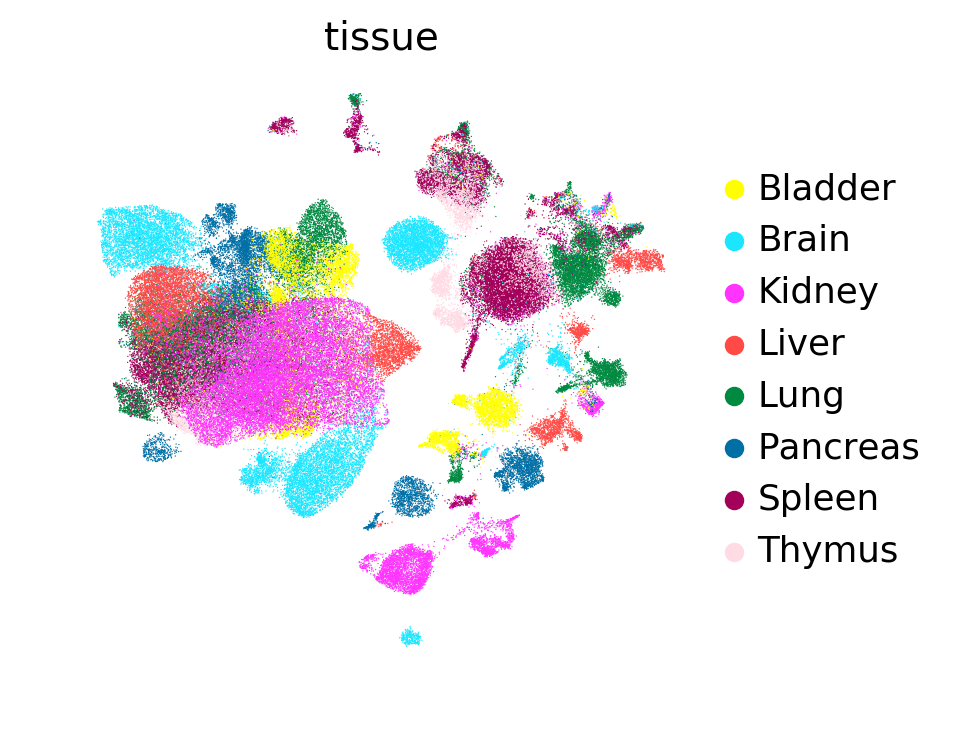

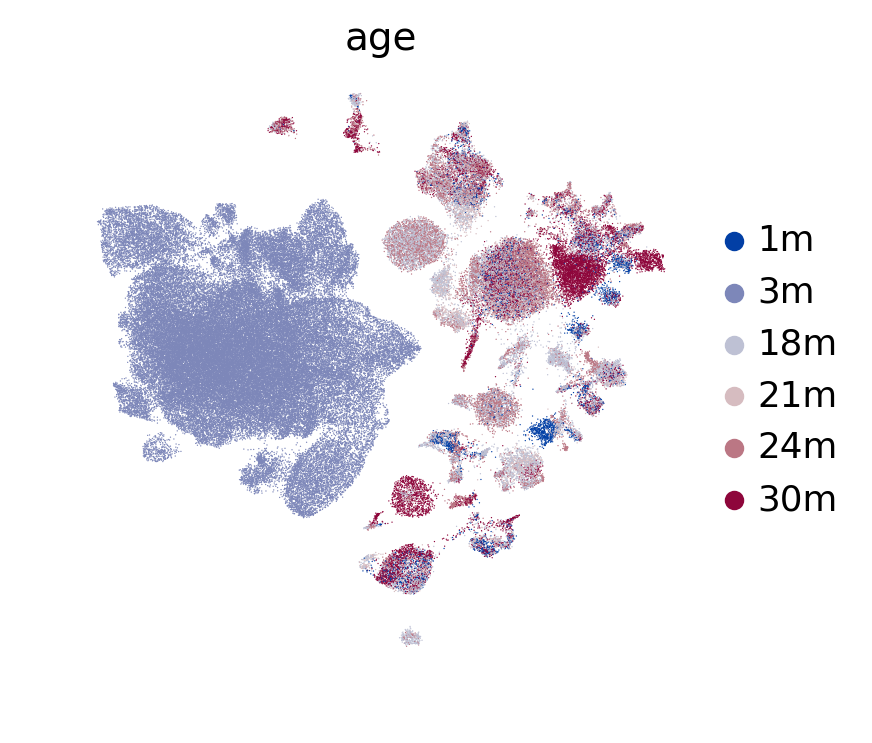

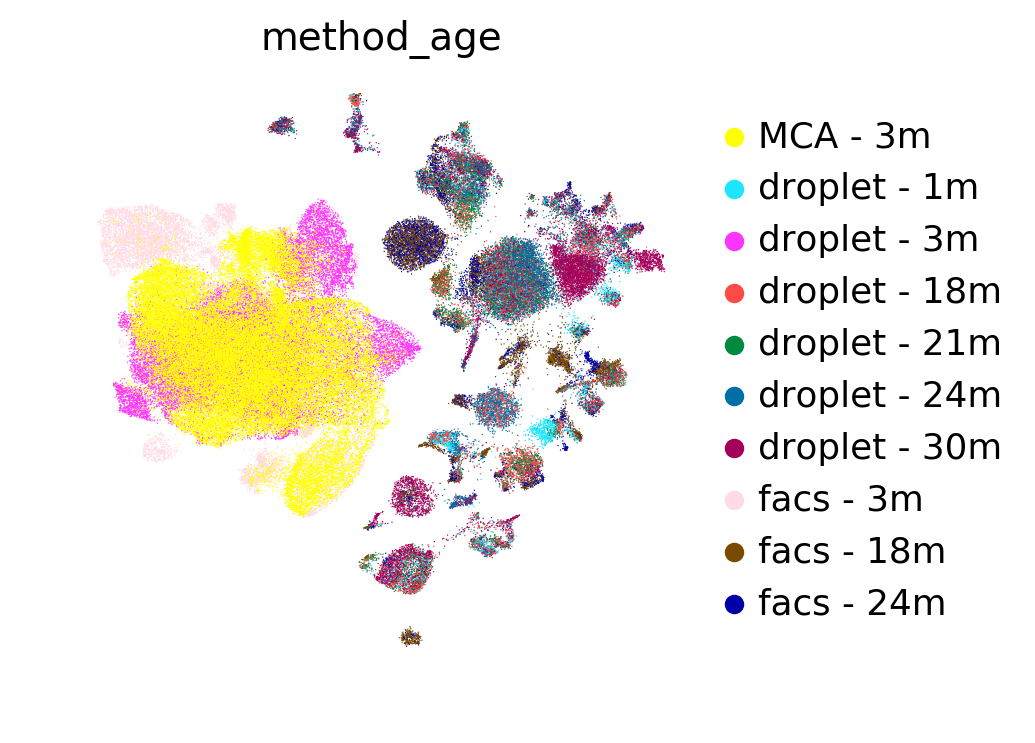

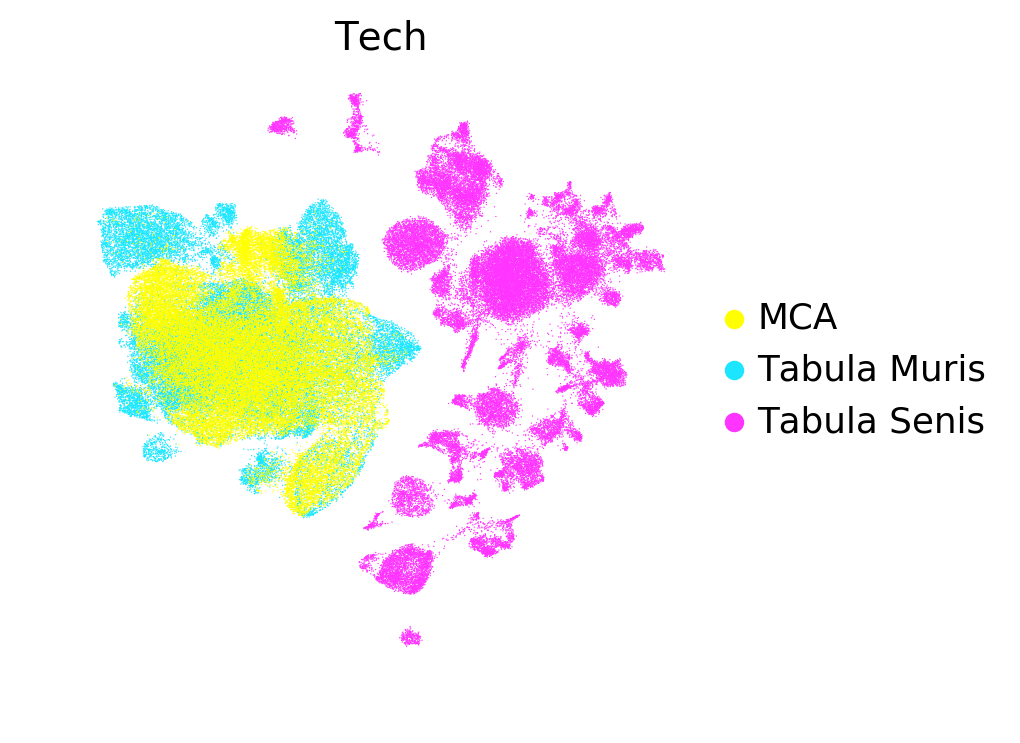

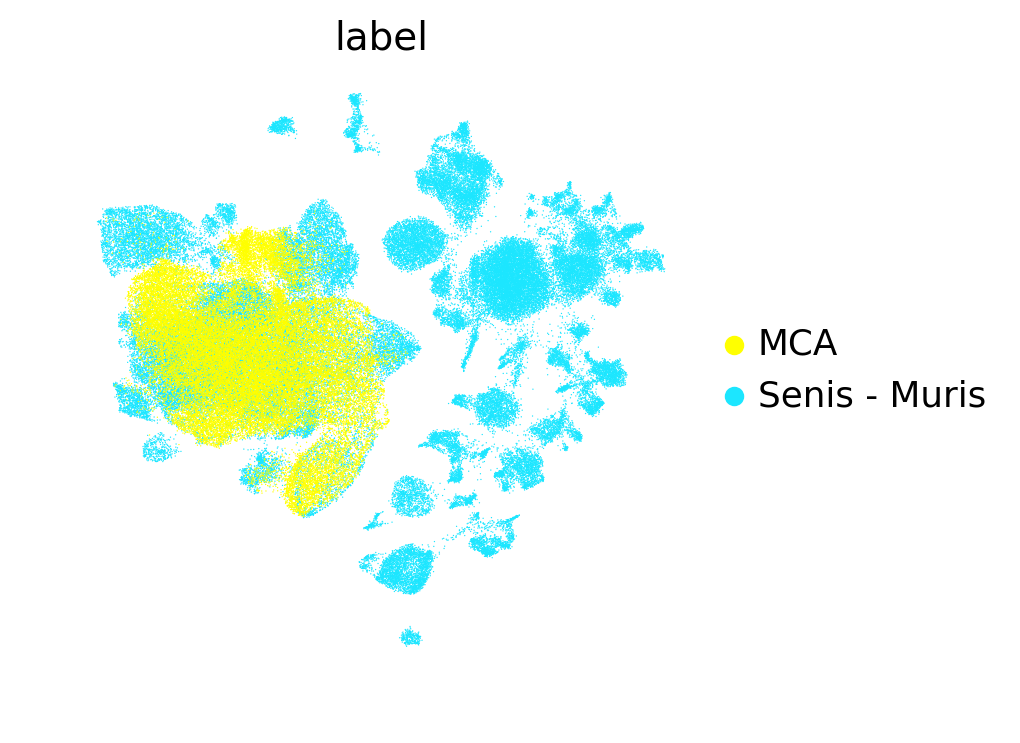

In [33]:
sc.pl.umap(latent_adata, color='method', frameon=False, save='_after_surgery_senis+mca+muris_method.pdf')
sc.pl.umap(latent_adata, color='tissue', frameon=False, save='_after_surgery_senis+mca+muris_tissue.pdf', palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(latent_adata, color='age', frameon=False, save='_after_surgery_senis+mca+muris_age.pdf', palette=sc.pl.palettes.zeileis_28)
sc.pl.umap(latent_adata, color=condition_key, frameon=False, save=f'_after_surgery_senis+mca+muris_{condition_key}.pdf', palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(latent_adata, color='Tech', frameon=False, save=f'_after_surgery_senis+mca+muris_Tech.pdf', palette=sc.pl.palettes.godsnot_102)
sc.pl.umap(latent_adata, color='label', frameon=False, save=f'_after_surgery_senis+mca+muris_Label.pdf', palette=sc.pl.palettes.vega20_scanpy)

# Weighted KNN

In [48]:
n_neighbors = [20]
thresholds = [0.5]

In [44]:
senis_adata = adata_for_training
muris_adata = adata_out_of_sample[adata_out_of_sample.obs['Tech'] == 'Tabula Muris']
mca_adata = adata_out_of_sample[adata_out_of_sample.obs['Tech'] == 'MCA']

In [45]:
train_adata = senis_adata.concatenate(muris_adata)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.


In [46]:
encoder_labels, _ = sn.utils.label_encoder(train_adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [47]:
train_latent = new_network.to_mmd_layer(train_adata, encoder_labels, encoder_labels)
train_latent

AnnData object with n_obs × n_vars = 89513 × 32 
    obs: 'FACS.selection', 'Tech', 'age', 'barcode', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cell_type_union', 'channel', 'free_annotation', 'log_counts', 'marker_gene', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'subtissue', 'tissue', 'tissue_age', 'tissue_free_annotation'

In [48]:
encoder_labels, _ = sn.utils.label_encoder(mca_adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [49]:
valid_latent = new_network.to_mmd_layer(mca_adata, encoder_labels, encoder_labels)
valid_latent

AnnData object with n_obs × n_vars = 42049 × 32 
    obs: 'FACS.selection', 'Tech', 'age', 'barcode', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'cell_type_union', 'channel', 'free_annotation', 'log_counts', 'marker_gene', 'method', 'method_age', 'method_tissue', 'mouse.id', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'subtissue', 'tissue', 'tissue_age', 'tissue_free_annotation'

In [50]:
tissues = valid_latent.obs['tissue'].unique().tolist()
tissues

['Pancreas', 'Lung', 'Brain', 'Bladder', 'Spleen', 'Thymus', 'Liver', 'Kidney']

In [51]:
for n_neighbor in n_neighbors:
    for threshold in thresholds:
        pred_labels, uncertainties = sn.utils.weighted_knn(train_latent, 
                                                                valid_latent, 
                                                                cell_type_key, 
                                                                n_neighbors=n_neighbor, 
                                                                threshold=threshold, 
                                                                pred_unknown=True, 
                                                                return_uncertainty=True,
                                                               )
        true_labels = np.array(valid_latent.obs[cell_type_key].values).reshape(-1, 1)

        labels_eval = pred_labels == true_labels
        labels_eval = labels_eval.astype(object)
        
        n_correct = len(labels_eval[labels_eval == True])
        n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
        n_unknown = len(labels_eval[pred_labels == 'Unknown'])
        
        labels_eval[labels_eval == True] = f'Correct ({n_correct})'
        labels_eval[labels_eval == False] = f'InCorrect ({n_incorrect})'
        labels_eval[pred_labels == 'Unknown'] = f'Unknown ({n_unknown})'
        
        labels_eval_key = f'labels_evaluation_w_unknown_{n_neighbor}_{threshold}'
        uncertainty_key = f'uncertainty_w_unknown_{n_neighbor}_{threshold}'
        pred_labels_key = f'predicted_labels_w_unknown_{n_neighbor}_{threshold}'
        
        valid_latent.obs[labels_eval_key] = pd.Categorical(labels_eval.reshape(-1, ))
        valid_latent.obs[uncertainty_key] = uncertainties
        valid_latent.obs[pred_labels_key] = pd.Categorical(pred_labels.reshape(-1, ))

Weighted KNN with n_neighbors = 10 and threshold = 0.2 ... finished!
Weighted KNN with n_neighbors = 10 and threshold = 0.3 ... finished!
Weighted KNN with n_neighbors = 10 and threshold = 0.5 ... finished!
Weighted KNN with n_neighbors = 20 and threshold = 0.2 ... finished!
Weighted KNN with n_neighbors = 20 and threshold = 0.3 ... finished!
Weighted KNN with n_neighbors = 20 and threshold = 0.5 ... finished!


In [52]:
valid_latent.obs.to_csv("./results/classification/tabula_senis_mca/senis+muris_to_mca.csv", index=None)

In [53]:
import seaborn as sns
from matplotlib import pyplot as plt

In [54]:
for tissue in tissues:
    print(f"{tissue} ...", end=' ')
    results_df = pd.DataFrame(columns=['k', 'prob', 'Correct', 'InCorrect', 'Unknown'])
    for n_neighbor in n_neighbors:
        for threshold in thresholds:
            
            new_row = {"k": n_neighbor, "prob": threshold}
            
            tissue_adata = valid_latent[valid_latent.obs['tissue'] == tissue]

            labels_eval_key = f'predicted_labels_w_unknown_{n_neighbor}_{threshold}'
            
            pred_labels = tissue_adata.obs[labels_eval_key].values
            true_labels = tissue_adata.obs[cell_type_key].values
            
            labels_eval = np.array(pred_labels) == np.array(true_labels)
            
            n_correct = len(labels_eval[labels_eval == True])
            n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
            n_unknown = len(labels_eval[pred_labels == 'Unknown'])

            new_row['Correct'] = n_correct
            new_row['InCorrect'] = n_incorrect
            new_row['Unknown'] = n_unknown

            results_df = results_df.append(new_row, ignore_index=True)
            
    results_df['k_prob'] = results_df.apply(lambda x: f'({x[0]}, {x[1]})', axis=1)
    results_df = results_df.sort_values('Correct', ascending=False)
    results_df_melted = pd.melt(results_df, id_vars=['k', 'prob', 'k_prob'], var_name='type', value_name='n_samples')

    sns.catplot(x='k_prob', y='n_samples', hue='type', data=results_df_melted, 
                kind='bar', height=20, aspect=0.5)
    plt.xticks(rotation=45)
    plt.savefig(f"./results/classification/tabula_senis_mca/hyperopt_muris_to_mca_{tissue}.pdf", bbox_inches='tight')
    plt.close()
    print('finished')

Pancreas ... finished
Lung ... finished
Brain ... finished
Bladder ... finished
Spleen ... finished
Thymus ... finished
Liver ... finished
Kidney ... finished


In [55]:
results_df = pd.DataFrame(columns=['k', 'prob', 'Correct', 'InCorrect', 'Unknown'])
for n_neighbor in n_neighbors:
    for threshold in thresholds:
        new_row = {"k": n_neighbor, "prob": threshold}

        labels_eval_key = f'predicted_labels_w_unknown_{n_neighbor}_{threshold}'

        pred_labels = valid_latent.obs[labels_eval_key].values
        true_labels = valid_latent.obs[cell_type_key].values

        labels_eval = np.array(pred_labels) == np.array(true_labels)

        n_correct = len(labels_eval[labels_eval == True])
        n_incorrect = len(labels_eval[labels_eval == False]) - len(labels_eval[pred_labels == 'Unknown'])
        n_unknown = len(labels_eval[pred_labels == 'Unknown'])

        new_row['Correct'] = n_correct
        new_row['InCorrect'] = n_incorrect
        new_row['Unknown'] = n_unknown

        results_df = results_df.append(new_row, ignore_index=True)

results_df['k_prob'] = results_df.apply(lambda x: f'({x[0]}, {x[1]})', axis=1)
results_df = results_df.sort_values('Correct', ascending=False)
results_df_melted = pd.melt(results_df, id_vars=['k', 'prob', 'k_prob'], var_name='type', value_name='n_samples')

sns.catplot(x='k_prob', y='n_samples', hue='type', data=results_df_melted, 
            kind='bar', height=20, aspect=0.5)
plt.xticks(rotation=45)
plt.savefig(f"./results/classification/tabula_senis_mca/hyperopt_muris_to_mca_all.pdf", bbox_inches='tight')
plt.close()